In [ ]:
import os
import requests
import zipfile
import glob
import shutil
import rasterio
import numpy as np
from osgeo import gdal, ogr, osr
from pathlib import Path
from rasterio.windows import from_bounds
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import fiona
import geopandas as gpd
from bmi_topography import Topography
from landlab.io import esri_ascii, write_esri_ascii
import matplotlib as mpl
import matplotlib.pyplot as plt
from landlab import imshowhs_grid, imshow_grid, imshow_grid_at_node
from matplotlib.colors import ListedColormap
import time

In [1]:
# ---- User inputs ----
clip_shapefile = 'Watershed/globalwatershed.shp'
target_resolution = 10  # meters
output_dir = 'landlab_ascii'
fire_name = 'Bolt Creek'
fire_id = 'WA4772812134620220910'

In [ ]:
# Load shapefile
gdf = gpd.read_file(clip_shapefile)

# Run a check to ensure shapefile is in UTM projection
if "UTM zone" in gdf.crs.to_wkt():
    # Already in UTM - just store EPSG code
    epsg_code = gdf.crs.to_epsg()
    crs = f"EPSG:{epsg_code}"
    print(f"Shapefile already in UTM: {crs}")
else:
    # If shapefile not in UTM projection
    # Convert to WGS84 first to get centroid in lon/lat
    centroid = gdf.to_crs(epsg=4326).geometry.unary_union.centroid
    zone = int((centroid.x + 180) / 6) + 1
    crs = f"EPSG:326{zone}"

    # Reproject and overwrite the shapefile
    gdf = gdf.to_crs(crs)
    gdf.to_file(clip_shapefile, driver="ESRI Shapefile")

print("CRS:", crs)

In [ ]:
# ---- Download USGS ~10m DEM using bmi-topography package ----
bounds = gpd.read_file(clip_shapefile).to_crs(epsg=4326).total_bounds
west, south, east, north = bounds
topo = Topography(
    dem_type="USGS10m",
    south=south-.05,
    north=north+.05,
    west=west-.05,
    east=east+.05,
    output_format="GTiff",
    cache_dir=output_dir,
    api_key="985ca66e17da97a20d0732c993597ea3"
    )
fname = topo.fetch()

In [ ]:
# ---- Reproject raster ----
def reproject_raster_to_match_crs(src_path, target_crs_epsg, resampling_method, template_meta=None):
    resampling_dict = {
        'nearest': Resampling.nearest,
        'bilinear': Resampling.bilinear,
        'cubic': Resampling.cubic,
        'average': Resampling.average,
        'mode': Resampling.mode
    }
    resampling_enum = resampling_dict.get(resampling_method, Resampling.nearest)

    with rasterio.open(src_path) as src:
        dst_crs = f"EPSG:{target_crs_epsg}"
        if template_meta is None:
            transform, width, height = calculate_default_transform(
                src.crs, dst_crs, src.width, src.height, *src.bounds
            )
        else:
            # Snap to DEM grid
            transform = template_meta['transform']
            width = template_meta['width']
            height = template_meta['height']

        kwargs = src.meta.copy()
        kwargs.update({'crs': dst_crs, 'transform': transform, 'width': width, 'height': height})

        reprojected_path = src_path.replace('.tif', f'_reproj_{target_crs_epsg}.tif')
        with rasterio.open(reprojected_path, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=resampling_enum
                )
    return reprojected_path


# ---- Clip raster ----
def clip_raster_to_shape(raster_path, shapefile_path, template_meta=None):
    with fiona.open(shapefile_path, "r") as shapefile:
        shapes = [feature["geometry"] for feature in shapefile]

    with rasterio.open(raster_path) as src:
        out_image, out_transform = mask(src, shapes, crop=True)
        out_meta = src.meta.copy()

    if template_meta is not None:
        # Snap clipped raster to DEM grid exactly
        out_meta.update({
            "driver": "GTiff",
            "height": template_meta['height'],
            "width": template_meta['width'],
            "transform": template_meta['transform']
        })
    else:
        # For DEM (first raster)
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })

    clipped_path = raster_path.replace('.tif', '_clipped.tif')
    with rasterio.open(clipped_path, "w", **out_meta) as dest:
        dest.write(out_image)
    return clipped_path


# ---- Resample raster ----
def resample_raster(raster_path, template_meta=None, resampling_method='nearest', target_resolution=None):
    resampling_dict = {
        'nearest': Resampling.nearest,
        'bilinear': Resampling.bilinear,
        'cubic': Resampling.cubic,
        'average': Resampling.average,
        'mode': Resampling.mode
    }
    resampling_enum = resampling_dict.get(resampling_method, Resampling.nearest)

    with rasterio.open(raster_path) as src:
        kwargs = src.meta.copy()

        if template_meta is not None:
            # Snap resampled grid to DEM alignment
            transform = template_meta['transform']
            width = template_meta['width']
            height = template_meta['height']
        else:
            transform = src.transform
            width = src.width
            height = src.height
            if target_resolution is not None:
                scale_x = src.res[0] / target_resolution
                scale_y = src.res[1] / target_resolution
                width = int(src.width * scale_x)
                height = int(src.height * scale_y)
                transform = rasterio.Affine(
                    target_resolution, transform.b, transform.c,
                    transform.d, -target_resolution, transform.f
                )

        kwargs.update({'transform': transform, 'width': width, 'height': height})

        resampled_path = raster_path.replace('.tif', f'_resampled.tif')
        with rasterio.open(resampled_path, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=src.crs,
                    resampling=resampling_enum
                )
    return resampled_path


# ---- Convert to ASCII ----
def convert_to_ascii(tif_path, out_dir, template_meta=None):
    os.makedirs(out_dir, exist_ok=True)

    with rasterio.open(tif_path) as src:
        array = src.read(1)
        meta = template_meta if template_meta is not None else src.meta

        transform = meta['transform']
        width = meta['width']
        height = meta['height']

        xllcorner = transform[2]
        yllcorner = transform[5] + transform[4] * (height - 1) if transform[4] < 0 else transform[5] - transform[4] * (height - 1)
        cellsize = abs(transform[0])

        nodata_value = src.nodata if src.nodata is not None else -9999.0

        ascii_path = os.path.join(out_dir, os.path.basename(tif_path).replace('.tif', '.asc'))
        with open(ascii_path, 'w') as f:
            f.write(f"ncols         {width}\n")
            f.write(f"nrows         {height}\n")
            f.write(f"xllcorner     {xllcorner}\n")
            f.write(f"yllcorner     {yllcorner}\n")
            f.write(f"cellsize      {cellsize}\n")
            f.write(f"NODATA_value  {nodata_value}\n")
            for row in array:
                row_out = [str(nodata_value) if np.isnan(v) else str(v) for v in row]
                f.write(" ".join(row_out) + "\n")
    return ascii_path

In [ ]:
#Match fire name and id to the case sensitive file names
fire_name_fmt = fire_name.lower().replace(" ", "_")
fire_id_fmt = fire_id.lower()

# Base URL
base_url = "https://edcintl.cr.usgs.gov/downloads/sciweb1/shared/MTBS_Fire/data/baer/"

# Compile dictionary to pass through data pipeline, where key = URL and item = resampling preference
urls = {
    "https://storage.googleapis.com/solus100pub/cec7_0_cm_p.tif":'bilinear',
    "https://storage.googleapis.com/solus100pub/anylithicdpt_cm_p.tif":'bilinear',
    "https://storage.googleapis.com/solus100pub/claytotal_0_cm_p.tif":'bilinear',
    "https://storage.googleapis.com/solus100pub/ph1to1h2o_0_cm_p.tif":'bilinear',
    "https://storage.googleapis.com/solus100pub/sandtotal_0_cm_p.tif":'bilinear',
    "https://storage.googleapis.com/solus100pub/silttotal_0_cm_p.tif":'bilinear',
    "https://storage.googleapis.com/solus100pub/dbovendry_0_cm_p.tif":'bilinear',
    "https://www.mrlc.gov/downloads/sciweb1/shared/mrlc/data-bundles/Annual_NLCD_LndCov_2021_CU_C1V1.zip":'nearest',
    # Possible burn severity URL formats
    f"{base_url}{fire_name_fmt}_sbs.zip":'nearest',
    f"{base_url}{fire_name_fmt}_{fire_id_fmt}_sbs.zip":'nearest'
}


In [ ]:
# ---- Create a list for storing output file names ----
ascii_files = []

# ---- Process DEM first ----
dem_reproj = reproject_raster_to_match_crs(str(fname), target_crs_epsg=crs.split(':')[1], resampling_method='cubic')
dem_clipped = clip_raster_to_shape(dem_reproj, clip_shapefile)
dem_resampled = resample_raster(dem_clipped, template_meta=None, resampling_method='cubic', target_resolution=target_resolution)
dem_ascii = convert_to_ascii(dem_resampled, output_dir, template_meta=None)

with rasterio.open(dem_resampled) as src:
    template_meta = src.meta.copy()  # lock DEM grid as template

# ---- Storing ASCII file names as we create them into a list so adding them to the model grid later requires no effort from the user ----
ascii_files.append(dem_ascii)

# ---- Process all other rasters ----
for url, method in urls.items():
    local_path = None

    # Handle ZIP input
    if url.lower().endswith(".zip"):
        zip_filename = os.path.join(output_dir, os.path.basename(url))
        extract_dir = os.path.join(output_dir, "unzipped")

        for attempt in range(5):
            try:
                mode, downloaded = ('ab', os.path.getsize(zip_filename)) if os.path.exists(zip_filename) else ('wb', 0)
                headers = {"Range": f"bytes={downloaded}-"} if downloaded else {}

                with requests.get(url, headers=headers, stream=True, timeout=60) as r:
                    r.raise_for_status()
                    total_size = int(r.headers.get("Content-Length", 0)) + downloaded
                    with open(zip_filename, mode) as f:
                        for chunk in r.iter_content(chunk_size=1024 * 1024 * 50):
                            if chunk:
                                f.write(chunk)
                                downloaded += len(chunk)
                if downloaded >= total_size:
                    break
            except Exception:
                time.sleep(5)
        else:
            print(f"Failed to download {url}")
            continue

        if not os.path.exists(extract_dir):
            with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
                zip_ref.extractall(extract_dir)

        tif_files = [os.path.join(root, f)
                     for root, _, files in os.walk(extract_dir)
                     for f in files if f.lower().endswith(".tif")]
        if not tif_files:
            continue
        local_path = tif_files[0]

    # Handle TIFF input
    elif url.lower().endswith(".tif"):
        if url.startswith("http"):
            local_path = os.path.join(output_dir, os.path.basename(url))
            os.makedirs(output_dir, exist_ok=True)
            if not os.path.exists(local_path):
                try:
                    r = requests.get(url, stream=True, timeout=60)
                    r.raise_for_status()
                    with open(local_path, 'wb') as f:
                        for chunk in r.iter_content(chunk_size=1024 * 1024):
                            f.write(chunk)
                except Exception as e:
                    print(f"Download failed for {url}: {e}")
                    continue
        else:
            local_path = url
    else:
        print(f"Check file type: {url}")
        continue

    # ---- Process and snap to DEM grid ----
    try:
        reprojected = reproject_raster_to_match_crs(local_path, target_crs_epsg=crs.split(':')[1], resampling_method=method, template_meta=template_meta)
        resampled = resample_raster(reprojected, template_meta=template_meta, resampling_method=method, target_resolution=target_resolution)
        clipped = clip_raster_to_shape(resampled, clip_shapefile, template_meta=template_meta)
        ascii_file = convert_to_ascii(clipped, output_dir, template_meta=template_meta)
        ascii_files.append(ascii_file)
    except Exception as e:
        print(f"Failed processing {local_path}: {e}")
        continue

    # ---- Remove intermediate files ----
    for item in os.listdir(output_dir):
        item_path = os.path.join(output_dir, item)
        try:
            if os.path.isfile(item_path) and item_path.lower().endswith(('.tif', '.zip')):
                os.remove(item_path)
            elif os.path.isdir(item_path):
                shutil.rmtree(item_path)
        except Exception as e:
            print(f"Could not delete {item_path}: {e}")

✅ ASCII file created: landlab_ascii/cec7_0_cm_p_reproj_32610_resampled_clipped.asc
✅ ASCII file created: landlab_ascii/anylithicdpt_cm_p_reproj_32610_resampled_clipped.asc
✅ ASCII file created: landlab_ascii/claytotal_0_cm_p_reproj_32610_resampled_clipped.asc
✅ ASCII file created: landlab_ascii/ph1to1h2o_0_cm_p_reproj_32610_resampled_clipped.asc
✅ ASCII file created: landlab_ascii/sandtotal_0_cm_p_reproj_32610_resampled_clipped.asc
✅ ASCII file created: landlab_ascii/silttotal_0_cm_p_reproj_32610_resampled_clipped.asc
✅ ASCII file created: landlab_ascii/dbovendry_0_cm_p_reproj_32610_resampled_clipped.asc
✅ ASCII file created: landlab_ascii/Annual_NLCD_LndCov_2021_CU_C1V1_reproj_32610_resampled_clipped.asc
✅ ASCII file created: landlab_ascii/bolt_creek_sbs_reproj_32610_resampled_clipped.asc
Failed to download https://edcintl.cr.usgs.gov/downloads/sciweb1/shared/MTBS_Fire/data/baer/bolt_creek_wa4772812134620220910_sbs.zip


In [ ]:
ascii_files

['landlab_ascii/USGS10m_47.673459564695776_-121.42375475862778_47.800298429024565_-121.28857107451766_reproj_32610_clipped_resampled.asc',
 'landlab_ascii/cec7_0_cm_p_reproj_32610_resampled_clipped.asc',
 'landlab_ascii/anylithicdpt_cm_p_reproj_32610_resampled_clipped.asc',
 'landlab_ascii/claytotal_0_cm_p_reproj_32610_resampled_clipped.asc',
 'landlab_ascii/ph1to1h2o_0_cm_p_reproj_32610_resampled_clipped.asc',
 'landlab_ascii/sandtotal_0_cm_p_reproj_32610_resampled_clipped.asc',
 'landlab_ascii/silttotal_0_cm_p_reproj_32610_resampled_clipped.asc',
 'landlab_ascii/dbovendry_0_cm_p_reproj_32610_resampled_clipped.asc',
 'landlab_ascii/Annual_NLCD_LndCov_2021_CU_C1V1_reproj_32610_resampled_clipped.asc',
 'landlab_ascii/bolt_creek_sbs_reproj_32610_resampled_clipped.asc']

In [ ]:
# Open ASCII file and record the NO_DATA value
# Load data as grid
# Store Data in RasterModelGrid format and add as field to grid
# close nodes at NO_DATA cells
# rename file to fit Landlab nomenclature ('your__field_name')
with open(ascii_files[0], "r") as f:
    nodata_val = None
    for line in f:
        if line.strip().upper().startswith("NODATA_VALUE"):
            nodata_val = float(line.split()[1])
            break
if nodata_val is None:
   nodata_val = -9999.

with open(ascii_files[0]) as f:
    grid = esri_ascii.load(f, name="topographic__elevation")

elev = grid.at_node["topographic__elevation"]

grid.set_nodata_nodes_to_closed(elev, nodata_val)

os.rename(ascii_files[0], os.path.join(os.path.dirname(ascii_files[0]), "topographic__elevation.asc"))

In [ ]:
# Open ASCII file and record the NO_DATA value
# Load data as grid
# Store Data in RasterModelGrid format and add as field to grid
# close nodes at NO_DATA cells
# rename file to fit Landlab nomenclature ('your__field_name')
with open(ascii_files[1], "r") as f:
    nodata_val = None
    for line in f:
        if line.strip().upper().startswith("NODATA_VALUE"):
            nodata_val = float(line.split()[1])
            break
if nodata_val is None:
   nodata_val = -9999.

with open(ascii_files[1]) as f:
    grid_1 = esri_ascii.load(f, name="cation__exchange_capacity")

cec = grid_1.at_node["cation__exchange_capacity"]

_=grid.add_field('cation__exchange_capacity', cec/10, at='node', clobber=True)

grid.set_nodata_nodes_to_closed(cec, nodata_val)

os.rename(ascii_files[1], os.path.join(os.path.dirname(ascii_files[1]), "cation__exchange_capacity.asc"))

In [ ]:
# Open ASCII file and record the NO_DATA value
# Load data as grid
# Store Data in RasterModelGrid format and add as field to grid
# close nodes at NO_DATA cells
# rename file to fit Landlab nomenclature ('your__field_name')
with open(ascii_files[2], "r") as f:
    nodata_val = None
    for line in f:
        if line.strip().upper().startswith("NODATA_VALUE"):
            nodata_val = float(line.split()[1])
            break
if nodata_val is None:
   nodata_val = -9999.

with open(ascii_files[2]) as f:
    grid_2 = esri_ascii.load(f, name="soil__thickness")

hs = grid_2.at_node["soil__thickness"]

_=grid.add_field('soil__thickness', hs/100, at='node', clobber=True)

grid.set_nodata_nodes_to_closed(hs, nodata_val)

os.rename(ascii_files[2], os.path.join(os.path.dirname(ascii_files[2]), "soil__thickness.asc"))

In [ ]:
# Open ASCII file and record the NO_DATA value
# Load data as grid
# Store Data in RasterModelGrid format and add as field to grid
# close nodes at NO_DATA cells
# rename file to fit Landlab nomenclature ('your__field_name')
with open(ascii_files[3], "r") as f:
    nodata_val = None
    for line in f:
        if line.strip().upper().startswith("NODATA_VALUE"):
            nodata_val = float(line.split()[1])
            break
if nodata_val is None:
   nodata_val = -9999.

with open(ascii_files[3]) as f:
    grid_3 = esri_ascii.load(f, name="clay__total")

cl = grid_3.at_node["clay__total"]

_=grid.add_field('clay__total', cl, at='node', clobber=True)

grid.set_nodata_nodes_to_closed(cl, nodata_val)

os.rename(ascii_files[3], os.path.join(os.path.dirname(ascii_files[3]), "clay__total.asc"))

In [ ]:
# Open ASCII file and record the NO_DATA value
# Load data as grid
# Store Data in RasterModelGrid format and add as field to grid
# close nodes at NO_DATA cells
# rename file to fit Landlab nomenclature ('your__field_name')
with open(ascii_files[4], "r") as f:
    nodata_val = None
    for line in f:
        if line.strip().upper().startswith("NODATA_VALUE"):
            nodata_val = float(line.split()[1])
            break
if nodata_val is None:
   nodata_val = -9999.

with open(ascii_files[4]) as f:
    grid_4 = esri_ascii.load(f, name="pH")

ph = grid_4.at_node["pH"]

_=grid.add_field('pH', ph/100, at='node', clobber=True)

grid.set_nodata_nodes_to_closed(ph, nodata_val)

os.rename(ascii_files[4], os.path.join(os.path.dirname(ascii_files[4]), "pH.asc"))

In [ ]:
# Open ASCII file and record the NO_DATA value
# Load data as grid
# Store Data in RasterModelGrid format and add as field to grid
# close nodes at NO_DATA cells
# rename file to fit Landlab nomenclature ('your__field_name')
with open(ascii_files[5], "r") as f:
    nodata_val = None
    for line in f:
        if line.strip().upper().startswith("NODATA_VALUE"):
            nodata_val = float(line.split()[1])
            break
if nodata_val is None:
   nodata_val = -9999.

with open(ascii_files[5]) as f:
    grid_5 = esri_ascii.load(f, name="sand__total")

sa = grid_5.at_node["sand__total"]

_=grid.add_field('sand__total', sa, at='node', clobber=True)

grid.set_nodata_nodes_to_closed(sa, nodata_val)

os.rename(ascii_files[5], os.path.join(os.path.dirname(ascii_files[5]), "sand__total.asc"))

In [ ]:
# Open ASCII file and record the NO_DATA value
# Load data as grid
# Store Data in RasterModelGrid format and add as field to grid
# close nodes at NO_DATA cells
# rename file to fit Landlab nomenclature ('your__field_name')
with open(ascii_files[6], "r") as f:
    nodata_val = None
    for line in f:
        if line.strip().upper().startswith("NODATA_VALUE"):
            nodata_val = float(line.split()[1])
            break
if nodata_val is None:
   nodata_val = -9999.

with open(ascii_files[6]) as f:
    grid_6 = esri_ascii.load(f, name="silt__total")

si = grid_6.at_node["silt__total"]

_=grid.add_field('silt__total', si, at='node', clobber=True)

grid.set_nodata_nodes_to_closed(si, nodata_val)

os.rename(ascii_files[6], os.path.join(os.path.dirname(ascii_files[6]), "silt__total.asc"))

In [ ]:
# Open ASCII file and record the NO_DATA value
# Load data as grid
# Store Data in RasterModelGrid format and add as field to grid
# close nodes at NO_DATA cells
# rename file to fit Landlab nomenclature ('your__field_name')
with open(ascii_files[7], "r") as f:
    nodata_val = None
    for line in f:
        if line.strip().upper().startswith("NODATA_VALUE"):
            nodata_val = float(line.split()[1])
            break
if nodata_val is None:
   nodata_val = -9999.

with open(ascii_files[7]) as f:
    grid_7 = esri_ascii.load(f, name="dry__bulk_density")

db = grid_7.at_node["dry__bulk_density"]

_=grid.add_field('dry__bulk_density', db/100, at='node', clobber=True)

grid.set_nodata_nodes_to_closed(db, nodata_val)

os.rename(ascii_files[7], os.path.join(os.path.dirname(ascii_files[7]), "dry__bulk_density.asc"))

In [ ]:
# Open ASCII file and record the NO_DATA value
# Load data as grid
# Store Data in RasterModelGrid format and add as field to grid
# close nodes at NO_DATA cells
# rename file to fit Landlab nomenclature ('your__field_name')
with open(ascii_files[8], "r") as f:
    nodata_val = None
    for line in f:
        if line.strip().upper().startswith("NODATA_VALUE"):
            nodata_val = float(line.split()[1])
            break
if nodata_val is None:
   nodata_val = -9999.

with open(ascii_files[8]) as f:
    grid_8 = esri_ascii.load(f, name="landcover")

C = grid_8.at_node["landcover"]

_=grid.add_field('landcover', C, at='node', clobber=True)

grid.set_nodata_nodes_to_closed(C, nodata_val)
grid.set_nodata_nodes_to_closed(C, 11)

os.rename(ascii_files[8], os.path.join(os.path.dirname(ascii_files[8]), "landcover.asc"))

In [ ]:
# Open ASCII file and record the NO_DATA value
# Load data as grid
# Store Data in RasterModelGrid format and add as field to grid
# close nodes at NO_DATA cells
# rename file to fit Landlab nomenclature ('your__field_name')
with open(ascii_files[9], "r") as f:
    nodata_val = None
    for line in f:
        if line.strip().upper().startswith("NODATA_VALUE"):
            nodata_val = float(line.split()[1])
            break
if nodata_val is None:
   nodata_val = -9999.

with open(ascii_files[9]) as f:
    grid_9 = esri_ascii.load(f, name="burn__severity")

bs = grid_9.at_node["burn__severity"]

bs[~np.isin(bs, [2, 3, 4])] = 1

_=grid.add_field('burn__severity', bs, at='node', clobber=True)

os.rename(ascii_files[9], os.path.join(os.path.dirname(ascii_files[9]), "burn__severity.asc"))

In [ ]:
# Compute Ksat as a function of pH, Clay and Silt percent mass totals, and cation exchange capacity
ksat = 10**(0.40220 + (0.26122 * grid.at_node['pH']) + 0.44565 - (0.02329 * grid.at_node['clay__total']) - (0.01265 * grid.at_node['silt__total']) - (0.01038 * grid.at_node['cation__exchange_capacity']))

In [ ]:
# Store Ksat in grid at node
_=grid.add_field('soil__saturated_hydraulic_conductivity', (ksat/100)*10, at='node', clobber=True) #m/day, includes lateral flow

In [ ]:
# Store Ksat in output directory as ASCII
write_esri_ascii(os.path.join(output_dir, 'soil__saturated_hydraulic_conductivity.asc'), grid, 'soil__saturated_hydraulic_conductivity', clobber=True)

['landlab_ascii/soil__saturated_hydraulic_conductivity.asc']

In [ ]:
# Compute transmissivity as a function of Ksat and soil thickness
To=grid.at_node['soil__saturated_hydraulic_conductivity']*grid.at_node['soil__thickness'] #m^2/day

# To avoid division by 0 errors
for i in range(len(To)):
    if To[i] < 0.1:
        To[i] = 0.1

# Store Ksat in grid at node
_=grid.add_field('soil__transmissivity', To, at='node', clobber=True)

In [ ]:
# Store transmissivity in output directory as ASCII
write_esri_ascii(os.path.join(output_dir, 'soil__transmissivity.asc'), grid, 'soil__transmissivity', clobber=True)

['landlab_ascii/soil__transmissivity.asc']

In [ ]:
# Compute saturated water content as a function of dry bulk density, Clay and Silt percent mass totals
wsat = 0.83080 - (0.28217 * grid.at_node['dry__bulk_density']) + (0.0002728 * grid.at_node['clay__total']) + (0.000187 * grid.at_node['silt__total'])

In [ ]:
# Store in grid at node
_=grid.add_field('saturated__water_content', wsat, at='node', clobber=True) #volume fraction

In [ ]:
# Store in output directory as ASCII
write_esri_ascii(os.path.join(output_dir, 'saturated__water_content.asc'), grid, 'saturated__water_content', clobber=True)

['landlab_ascii/saturated__water_content.asc']

In [ ]:
# Classify soil texture from total mass % of sand, clay, and/or silt
# using classification thresholds outlined in the USDA soil textural triangle
def classify_soil_texture(sand, silt, clay):
    if sand >= 85 and (silt + 1.5 * clay) < 15:
        return 1
    elif sand >= 70 and sand <= 91 and (silt + 1.5 * clay) >= 15 and (silt + 2 * clay) < 30:
        return 2
    elif clay >= 7 and clay <= 20 and sand > 52 and (silt + 2 * clay) >= 30:
        return 3
    elif clay < 7 and silt < 50 and sand > 43:
        return 3
    elif clay >= 7 and clay <= 27 and silt >= 28 and silt <= 50 and sand <= 52:
        return 4
    elif clay >= 12 and clay <= 27 and silt >= 50:
        return 5
    elif clay < 12 and silt <= 80 and silt >= 50:
        return 5
    elif clay < 12 and silt >= 80:
        return 6
    elif clay >= 20 and clay <= 35 and silt < 28 and sand > 45:
        return 7
    elif clay >= 27 and clay <= 40 and sand < 46 and sand > 20:
        return 8
    elif clay >= 27 and clay <= 40 and sand <= 20:
        return 9
    elif clay >= 35 and sand >= 45:
        return 10
    elif clay >= 40 and sand >= 40:
        return 11
    elif clay >= 40 and sand <= 45 and silt < 40:
        return 12
    else:
        return 0

In [ ]:
soil_types = [
    classify_soil_texture(
        grid.at_node['sand__total'][i],
        grid.at_node['silt__total'][i],
        grid.at_node['clay__total'][i]
    )
    for i in range(len(grid.at_node['sand__total']))
]

In [ ]:
# store in grid at node
_=grid.add_field('soil__texture', soil_types, at='node', clobber=True)

In [ ]:
# Store in output directory as ASCII
write_esri_ascii(os.path.join(output_dir, 'soil__texture.asc'), grid, 'soil__texture', clobber=True)

['landlab_ascii/soil__texture.asc']

In [ ]:
# Lookup Table
# Uses literature consensus mapping for converting from USDA soil texture classification
# to Unified Soil Classification System (USCS) to estimate internal friction angle
# Uses Dingman Physical Hydrology (Second Edition) to calculate porosity, field capacity,
# and wilting point
def classify_fc_wp(soil_texture, saturated_water_content):

    psi_fc = 3.33 #m
    psi_wp = 350 #m

    if soil_texture == 1: #USDA - sand; USCS - SP (Poorly graded sand)
        phi = 30
        porosity = 0.395
        theta_fc = porosity*((.121/psi_fc)**(1/4.05))
        theta_wp = porosity*((.121/psi_wp)**(1/4.05))
    elif soil_texture == 2: #USDA - loamy sand; USCS - SM (silty sand/sand-silt mixtures)
        phi = 30
        porosity = 0.410
        theta_fc = porosity*((.090/psi_fc)**(1/4.38))
        theta_wp = porosity*((.090/psi_wp)**(1/4.38))
    elif soil_texture == 3: #USDA - sandy loam; USCS - SM (silty sand/sand-silt mixtures)
        phi = 30
        porosity = 0.435
        theta_fc = porosity*((.218/psi_fc)**(1/4.90))
        theta_wp = porosity*((.218/psi_wp)**(1/4.90))
    elif soil_texture == 4: # USDA - loam; USCS - CL (inorganic clays, gravelly sandy or silty)
        phi = 31
        porosity = 0.451
        theta_fc = porosity*((.478/psi_fc)**(1/5.39))
        theta_wp = porosity*((.478/psi_wp)**(1/5.39))
    elif soil_texture == 5: #USDA - silt loam; USCS - ML (inorganic silt, clayey silt)
        phi = 31
        porosity = 0.485
        theta_fc = porosity*((.786/psi_fc)**(1/5.30))
        theta_wp = porosity*((.786/psi_wp)**(1/5.30))
    elif soil_texture == 6: #silt; estimated from Dingman Physical Hydrology 3rd Edition Figures 8.2 (field capacity), 8.4 (wilting point)
        # USDA - silt; USCS - ML (inorganic silt, clayey silt)
        phi = 31
        porosity = saturated_water_content if saturated_water_content is not None else -9999.
        theta_fc = 0.2
        theta_wp = 0.075
    elif soil_texture == 7: #USDA - sandy clay loam; USCS - SC (clayey sand)
        phi = 27
        porosity = 0.420
        theta_fc = porosity*((.299/psi_fc)**(1/7.12))
        theta_wp = porosity*((.299/psi_wp)**(1/7.12))
    elif soil_texture == 8: #USDA - clay loam; USCS - CL (inorganic clays, gravelly sandy or silty)
        phi = 16
        porosity = 0.476
        theta_fc = porosity*((.630/psi_fc)**(1/8.52))
        theta_wp = porosity*((.630/psi_wp)**(1/8.52))
    elif soil_texture == 9: #USDA - silty clay loam; USCS - CL (inorganic clays, gravelly sandy or silty)
        phi = 16
        porosity = 0.477
        theta_fc = porosity*((.356/psi_fc)**(1/7.75))
        theta_wp = porosity*((.356/psi_wp)**(1/7.75))
    elif soil_texture == 10: #USDA - sandy clay; USCS - SC (clayey sand)
        phi = 27
        porosity = 0.426
        theta_fc = porosity*((.153/psi_fc)**(1/10.4))
        theta_wp = porosity*((.153/psi_wp)**(1/10.4))
    elif soil_texture == 11: #USDA - silty clay; USCS - CH (inorganic fat clays)
        phi = 16
        porosity = 0.492
        theta_fc = porosity*((.490/psi_fc)**(1/10.4))
        theta_wp = porosity*((.490/psi_wp)**(1/10.4))
    elif soil_texture == 12: #USDA - clay; USCS - CH (inorganic fat clays)
        phi = 16
        porosity = 0.482
        theta_fc = porosity*((.405/psi_fc)**(1/11.4))
        theta_wp = porosity*((.405/psi_wp)**(1/11.4))
    else:
        porosity = -9999.
        theta_fc = -9999.
        theta_wp = -9999.
        phi = -9999.

    return porosity, theta_fc, theta_wp, phi

In [ ]:
soil_porosity, soil_theta_fc, soil_theta_wp, internal_friction_angle = zip(*[
    classify_fc_wp(grid.at_node['soil__texture'][i], grid.at_node['saturated__water_content'][i])
    for i in range(len(grid.at_node['soil__texture']))
])

In [ ]:
# store in grid at node
_=grid.add_field('field__capacity', soil_theta_fc, at='node', clobber=True)
_=grid.add_field('wilting__point', soil_theta_wp, at='node', clobber=True)
_=grid.add_field('porosity', soil_porosity, at='node', clobber=True)
_=grid.add_field('soil__internal_friction_angle', internal_friction_angle, at='node', clobber=True)

In [ ]:
# Store in output directory as ASCII
write_esri_ascii(os.path.join(output_dir, 'field__capacity.asc'), grid, 'field__capacity', clobber=True)
write_esri_ascii(os.path.join(output_dir, 'wilting__point.asc'), grid, 'wilting__point', clobber=True)
write_esri_ascii(os.path.join(output_dir, 'porosity.asc'), grid, 'porosity', clobber=True)
write_esri_ascii(os.path.join(output_dir, 'soil__internal_friction_angle.asc'), grid, 'soil__internal_friction_angle', clobber=True)

['landlab_ascii/soil__internal_friction_angle.asc']

In [ ]:
# calculate soil density as a function of dry bulk density and porosity
# store in grid at node
_=grid.add_field('soil__density', (grid.at_node['dry__bulk_density']/(1 - grid.at_node['porosity']))*1000, at='node', clobber=True) #kg/m^3

In [ ]:
# Store in output directory as ASCII
write_esri_ascii(os.path.join(output_dir, 'soil__density.asc'), grid, 'soil__density', clobber=True)

['landlab_ascii/soil__density.asc']

In [ ]:
# simplify NLCS land cover classifications to bare/developed, forest, shrub, herbaceous/grassy, wetland
def rootcohesion(C, nd, b, f, s, h, w):
    nC = []
    for i in C:
        if i == 250:
            nC.append(nd)
        elif i in [12, 21, 22, 23, 24, 31]:
            nC.append(b) # bare/developed
        elif i in [41, 42, 43]:
            nC.append(f) # forest
        elif i in [51, 52]:
            nC.append(s) # shrub
        elif i in [71, 72, 73, 74, 81, 82]:
            nC.append(h) # herbaceous
        elif i in [90, 95]:
            nC.append(w) # wetland
        else:
            nC.append(nd)
    return nC

In [ ]:
nC = rootcohesion(C,0,1,2,3,4,5)

In [ ]:
# store at node in grid
grid.add_field('landcovercolor', nC, at='node', clobber=True)

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
# increase soil internal friction angle by 3 degrees at developed cells to account for compression
for i in range(len(grid.at_node['landcover'])):
    if grid.at_node['landcover'][i] in [21, 22, 23, 24]:
        grid.at_node['soil__internal_friction_angle'][i] += 3.0

In [ ]:
# assign cohesion values (Pa) based on land cover classification according to Strauch et al. (2018)
C_min = rootcohesion(C,-9999.,30, 4000, 2000, 1000, 3000)
C_mode = rootcohesion(C,-9999.,100, 10000, 4000, 2000, 6000)
C_max = rootcohesion(C,-9999.,150, 20000, 10000, 5000, 14000)

In [ ]:
# store in grid at node
grid.add_field('soil__minimum_total_cohesion', C_min, at='node', clobber=True)
grid.add_field('soil__maximum_total_cohesion', C_max, at='node', clobber=True)
grid.add_field('soil__mode_total_cohesion', C_mode, at='node', clobber=True)

array([-9999., -9999., -9999., ..., -9999., -9999., -9999.])

In [ ]:
# Store in output directory as ASCII
write_esri_ascii(os.path.join(output_dir, 'soil__minimum_total_cohesion.asc'), grid, 'soil__minimum_total_cohesion', clobber=True)
write_esri_ascii(os.path.join(output_dir, 'soil__maximum_total_cohesion.asc'), grid, 'soil__maximum_total_cohesion', clobber=True)
write_esri_ascii(os.path.join(output_dir, 'soil__mode_total_cohesion.asc'), grid, 'soil__mode_total_cohesion', clobber=True)

['landlab_ascii/soil__mode_total_cohesion.asc']

In [ ]:
# simple conversion from NLCS land cover classifications to vegetation type
def vegtype(C, nd, bare, tree, shrub, grass):
    vC = []
    for i in C:
        if i == 250:
            vC.append(nd)
        elif i in [12, 21, 22, 23, 24, 31]:        # Bare
            vC.append(bare)
        elif i in [41, 42, 43, 90]:                # Tree (includes woody wetlands)
            vC.append(tree)
        elif i in [51, 52]:                        # Shrub/Scrub
            vC.append(shrub)
        elif i in [71, 72, 73, 74, 81, 82, 95]:    # Grass types + herbaceous wetlands
            vC.append(grass)
        else:
            vC.append(nd)
    return vC

In [ ]:
vegetation_type = vegtype(C,-9999.,3, 2, 1, 0)

In [ ]:
# store in grid at node
grid.add_field('vegetation__plant_functional_type', vegetation_type, at='node', clobber=True)

array([-9999., -9999., -9999., ..., -9999., -9999., -9999.])

In [ ]:
# Store in output directory as ASCII
write_esri_ascii(os.path.join(output_dir, 'vegetation__plant_functional_type.asc'), grid, 'vegetation__plant_functional_type', clobber=True)

['landlab_ascii/vegetation__plant_functional_type.asc']

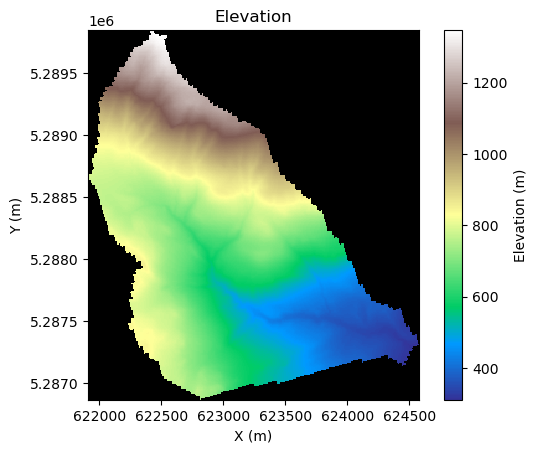

In [ ]:
imshow_grid(grid,'topographic__elevation', plot_name = 'Elevation',
            var_name = 'Elevation', var_units = 'm', grid_units = ('m','m'),
            cmap = 'terrain')

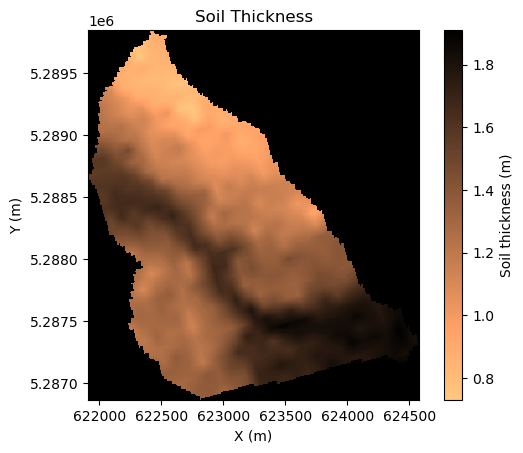

In [ ]:
imshow_grid(grid,'soil__thickness', plot_name = 'Soil Thickness',
            var_name = 'Soil thickness', var_units = 'm', grid_units = ('m','m'),
            cmap = 'copper_r')

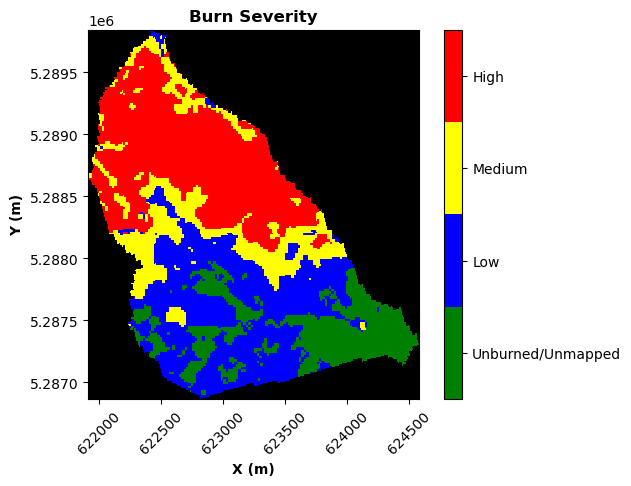

In [ ]:
imshow_grid_at_node(grid, 'burn__severity', plot_name = 'Burn Severity',
            cmap = ListedColormap(['green',"blue", "yellow", "red"], N=4), limits = (0.5,4.5), allow_colorbar= False)
cb = plt.colorbar()
cb.set_ticks([1,2,3,4])
cb.set_ticklabels(['Unburned/Unmapped', 'Low','Medium','High'])
plt.title('Burn Severity', fontweight='bold')
plt.xlabel('X (m)', fontweight='bold')
plt.ylabel('Y (m)', fontweight='bold')
plt.xticks(rotation=45)
plt.show()

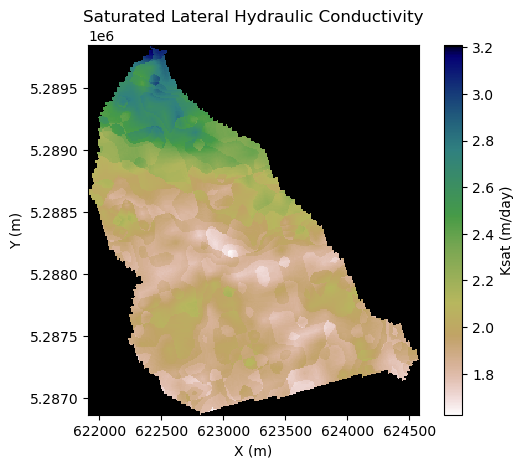

In [ ]:
imshow_grid(grid,'soil__saturated_hydraulic_conductivity', plot_name = 'Saturated Lateral Hydraulic Conductivity',
            var_name = 'Ksat', var_units = 'm/day', grid_units = ('m','m'),
            cmap = 'gist_earth_r')

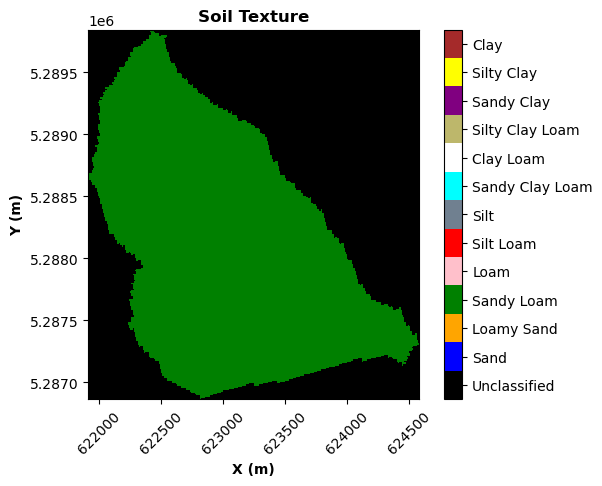

In [ ]:
imshow_grid_at_node(grid, 'soil__texture', plot_name = 'Soil Texture',
            cmap = ListedColormap(['k',"blue", "orange", "green", "pink", "red",
                        "slategray", "cyan", "white", "darkkhaki", "purple", "yellow", 'brown'], N=13), limits = (-0.5,12.5), allow_colorbar= False)
cb = plt.colorbar()
cb.set_ticks([0,1,2,3,4,5,6,7,8,9, 10, 11, 12])
cb.set_ticklabels(['Unclassified', 'Sand','Loamy Sand','Sandy Loam','Loam','Silt Loam', 'Silt',
                  'Sandy Clay Loam','Clay Loam', 'Silty Clay Loam','Sandy Clay', 'Silty Clay', 'Clay'])
plt.title('Soil Texture', fontweight='bold')
plt.xlabel('X (m)', fontweight='bold')
plt.ylabel('Y (m)', fontweight='bold')
plt.xticks(rotation=45)
plt.show()

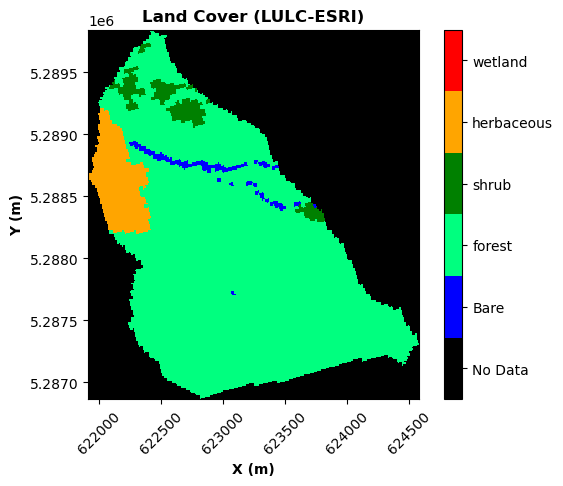

In [ ]:
imshow_grid_at_node(grid, 'landcovercolor', plot_name = 'Burmapinar Landcover Classifications',
            cmap = ListedColormap(['k',"blue", "springgreen", "green", "orange", "red",
                        "slategray", "cyan", "white", "darkkhaki"], N=6), limits = (-0.5,5.5), allow_colorbar= False)
cb = plt.colorbar()
cb.set_ticks([0,1,2,3,4,5])
cb.set_ticklabels(['No Data', 'Bare', 'forest', 'shrub', 'herbaceous', 'wetland'])
plt.title('Land Cover (LULC-ESRI)', fontweight='bold')
plt.xlabel('X (m)', fontweight='bold')
plt.ylabel('Y (m)', fontweight='bold')
plt.xticks(rotation=45)
plt.show()

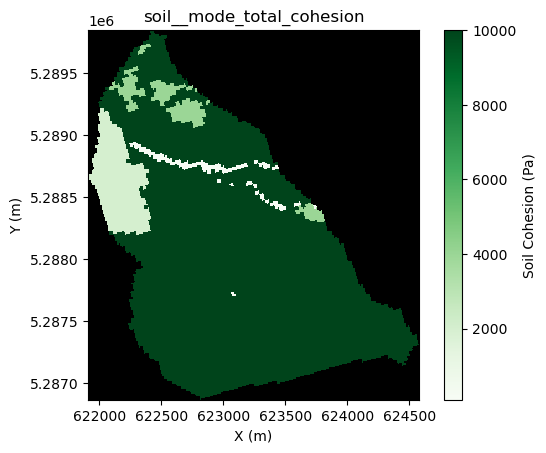

In [ ]:
imshow_grid_at_node(grid,'soil__mode_total_cohesion', plot_name = 'Mode cohesion',
            var_name = 'Soil Cohesion', var_units = 'Pa', grid_units = ('m','m'),
            cmap = 'Greens')

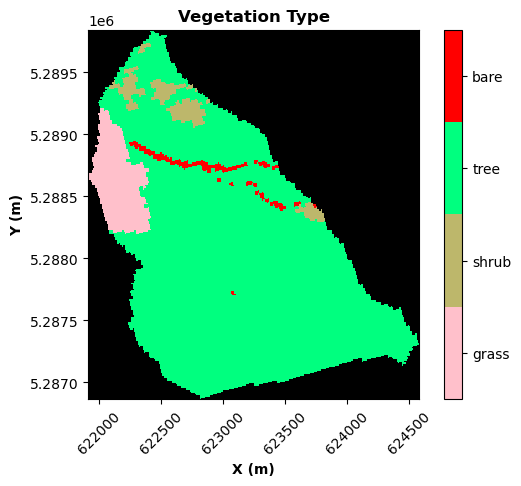

In [ ]:
imshow_grid_at_node(grid, 'vegetation__plant_functional_type', plot_name = 'Vegetation Type',
            cmap = ListedColormap(['pink',"darkkhaki", "springgreen", "red"], N=4), limits = (-0.5,3.5), allow_colorbar= False)
cb = plt.colorbar()
cb.set_ticks([0,1,2,3])
cb.set_ticklabels(['grass', 'shrub','tree','bare'])
plt.title('Vegetation Type', fontweight='bold')
plt.xlabel('X (m)', fontweight='bold')
plt.ylabel('Y (m)', fontweight='bold')
plt.xticks(rotation=45)
plt.show()